### Library

In [61]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

### Autoencoder Model

In [62]:
class Autoencoder_Linear_User(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super().__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim)
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim)
        )

    def forward(self, x):
        latent = self.encoder(x)  # Compress user profile
        reconstructed = self.decoder(latent)  # Reconstruct original profile
        return reconstructed, latent


### Load Data

In [63]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import json

# Load your profile data
profile_df = pd.read_csv("GeneratedProfiles.csv")

# Extract all possible categories
faculties = profile_df['faculty'].unique().tolist()
looking_for_options = profile_df['looking_for'].unique().tolist()

# Build interest, personality, and value pools
interest_pool, personality_pool, values_pool = set(), set(), set()
for row in profile_df['filter_preferences']:
    prefs = json.loads(row)
    interest_pool.update(prefs.get("1", []))
    personality_pool.update(prefs.get("2", []))
    values_pool.update(prefs.get("3", []))

interest_pool = sorted(interest_pool)
personality_pool = sorted(personality_pool)
values_pool = sorted(values_pool)

# Function to turn each profile into a numeric vector
def encode_profile(row):
    vec = []

    # One-hot encode 'faculty'
    vec += [1 if row['faculty'] == f else 0 for f in faculties]

    # One-hot encode 'looking_for'
    vec += [1 if row['looking_for'] == lf else 0 for lf in looking_for_options]

    # Numeric location features
    coords = json.loads(row['location'])["coords"]
    vec += [
        float(coords.get("latitude", 0)),
        float(coords.get("longitude", 0)),
        float(coords.get("accuracy", 0))
    ]

    # Multi-hot encode filter_preferences
    prefs = json.loads(row['filter_preferences'])

    vec += [1 if i in prefs.get("1", []) else 0 for i in interest_pool]        # Interests
    vec += [1 if p in prefs.get("2", []) else 0 for p in personality_pool]     # Personality
    vec += [1 if v in prefs.get("3", []) else 0 for v in values_pool]          # Values

    return vec

# Apply to all rows
X = profile_df.apply(encode_profile, axis=1).tolist()

# Convert to PyTorch tensor
X_tensor = torch.tensor(X, dtype=torch.float32)

# Build the dataset and data loader
dataset = TensorDataset(X_tensor)
data_loader = DataLoader(dataset, batch_size=32, shuffle=True)

### Model Initialization

In [64]:
X_tensor.shape

torch.Size([20, 46])

In [65]:
X_tensor.shape[1]

46

In [66]:
input_dim = X_tensor.shape[1]
latent_dim = 10

model = Autoencoder_Linear_User(input_dim, latent_dim) # Initialize Autoencoder Model
criterion = nn.MSELoss() # Define loss function (reconstruction error)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5) # Adjust weights to minimize loss

### Model Training

In [67]:
# training
num_epochs = 20000
outputs = []
for epoch in range(num_epochs):
    for batch in data_loader:
        batch_data = batch[0] # Extract batch
        reconstructed, latent = model(batch_data) # Forward pass
        loss = criterion(reconstructed, batch_data) # Compute reconstruction loss

        optimizer.zero_grad() # Reset gradients
        loss.backward() # Compute gradients
        optimizer.step() # Update model parameters
 
    print(f"Epoch:{epoch+1}, Loss:{loss.item():.4f}")
    outputs.append((epoch, batch_data, reconstructed, loss))

Epoch:1, Loss:259.9587
Epoch:2, Loss:259.0977
Epoch:3, Loss:258.0649
Epoch:4, Loss:256.8161
Epoch:5, Loss:255.2353
Epoch:6, Loss:253.2412
Epoch:7, Loss:250.8433
Epoch:8, Loss:247.9635
Epoch:9, Loss:244.5634
Epoch:10, Loss:240.5718
Epoch:11, Loss:235.9132
Epoch:12, Loss:230.5309
Epoch:13, Loss:224.2967
Epoch:14, Loss:217.1017
Epoch:15, Loss:208.8524
Epoch:16, Loss:199.4728
Epoch:17, Loss:188.9113
Epoch:18, Loss:177.0766
Epoch:19, Loss:163.9442
Epoch:20, Loss:149.5367
Epoch:21, Loss:133.9590
Epoch:22, Loss:117.4035
Epoch:23, Loss:100.1554
Epoch:24, Loss:82.5853
Epoch:25, Loss:65.3586
Epoch:26, Loss:49.3395
Epoch:27, Loss:35.7650
Epoch:28, Loss:26.1195
Epoch:29, Loss:21.7235
Epoch:30, Loss:22.6709
Epoch:31, Loss:26.7819
Epoch:32, Loss:30.3985
Epoch:33, Loss:30.6212
Epoch:34, Loss:27.0511
Epoch:35, Loss:20.8942
Epoch:36, Loss:14.0363
Epoch:37, Loss:8.2247
Epoch:38, Loss:4.3623
Epoch:39, Loss:2.6113
Epoch:40, Loss:2.5834
Epoch:41, Loss:3.6704
Epoch:42, Loss:5.2669
Epoch:43, Loss:6.8704
Epoc

### Visualizations

#### Reconstruction Errors over Epochs

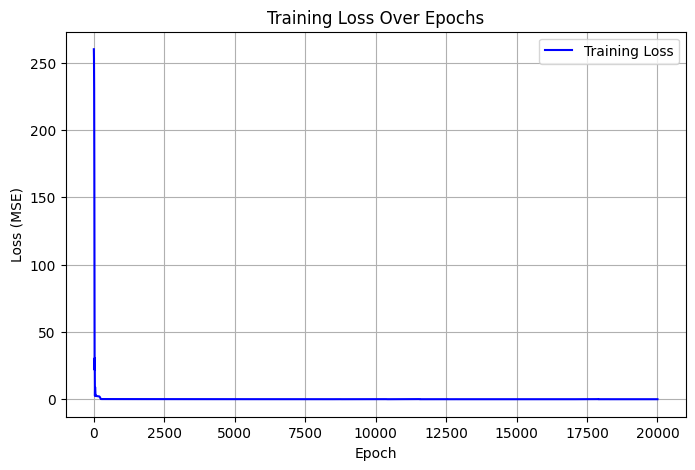

In [68]:
import matplotlib.pyplot as plt

# Extract losses from the outputs list
epochs = [epoch for epoch, _, _, loss in outputs]
losses = [loss.item() for _, _, _, loss in outputs]

# Plot training loss over epochs
plt.figure(figsize=(8, 5))
plt.plot(epochs, losses, label="Training Loss", color="blue")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.title("Training Loss Over Epochs")
plt.grid(True)
plt.legend()
plt.show()


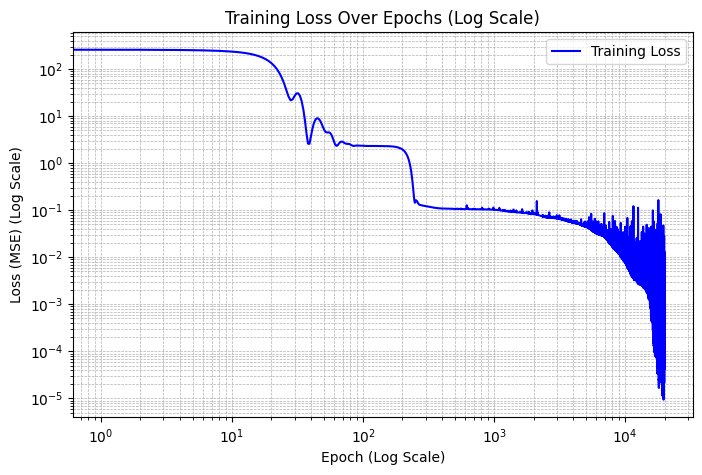

In [69]:
import matplotlib.pyplot as plt

# Extract losses from the outputs list
epochs = [epoch for epoch, _, _, loss in outputs]
losses = [loss.item() for _, _, _, loss in outputs]

# Plot training loss on a log scale
plt.figure(figsize=(8, 5))
plt.plot(epochs, losses, label="Training Loss", color="blue")
plt.xscale("log")  # Log scale for epochs
plt.yscale("log")  # Log scale for loss values
plt.xlabel("Epoch (Log Scale)")
plt.ylabel("Loss (MSE) (Log Scale)")
plt.title("Training Loss Over Epochs (Log Scale)")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.legend()
plt.show()


#### User Profiles in Latent Space

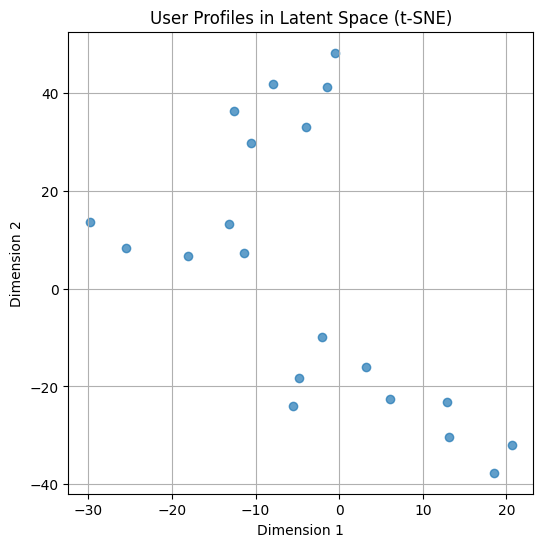

In [70]:
from sklearn.manifold import TSNE

# Get all latent vectors
with torch.no_grad():
    _, latents = model(X_tensor)

tsne = TSNE(n_components=2, perplexity=5, random_state=0)
embedded = tsne.fit_transform(latents.numpy())

plt.figure(figsize=(6, 6))
plt.scatter(embedded[:, 0], embedded[:, 1], alpha=0.7)
plt.title("User Profiles in Latent Space (t-SNE)")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.grid(True)
plt.show()


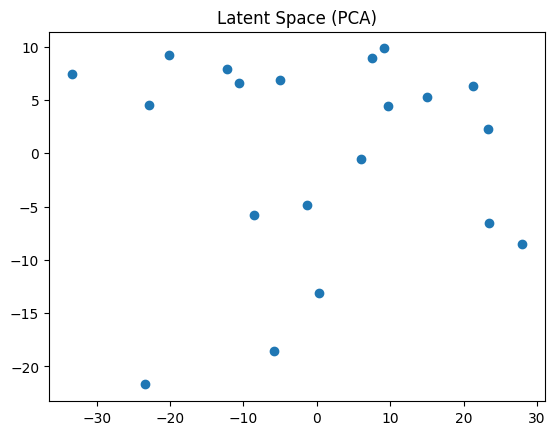

In [71]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_embed = pca.fit_transform(latents.numpy())

plt.scatter(pca_embed[:, 0], pca_embed[:, 1])
plt.title("Latent Space (PCA)")
plt.show()
